In [1]:
!gpustat

/usr/bin/gpustat:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
venus                       Sun Nov  3 21:21:00 2024  535.183.06
[0] NVIDIA GeForce RTX 4090 | 32'C,   0 % |   360 / 24564 MB | gdm(4M)
[1] NVIDIA GeForce RTX 4090 | 72'C,  96 % | 16120 / 24564 MB | zhangkejia(15756M) gdm(4M)
[2] NVIDIA GeForce RTX 4090 | 62'C,  97 % | 16152 / 24564 MB | zhangkejia(15788M) gdm(4M)
[3] NVIDIA GeForce RTX 4090 | 60'C,  97 % | 16136 / 24564 MB | zhangkejia(15772M) gdm(4M)
[4] NVIDIA GeForce RTX 4090 | 33'C,   0 % |   360 / 24564 MB | gdm(4M)
[5] NVIDIA GeForce RTX 4090 | 60'C,  97 % | 16114 / 24564 MB | zhangkejia(15750M) gdm(4M)
[6] NVIDIA GeForce RTX 4090 | 31'C,   0 % |   360 / 24564 MB | gdm(4M)
[7] NVIDIA GeForce RTX 4090 | 33'C,   0 % |  7056 / 24564 MB | zhouyufan(6692M) gdm(4M)


In [2]:

from pathlib import Path
import torch
from diffusers import StableDiffusionPipeline
from compel import Compel
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
DEFAULT_MODEL_ID = "stable-diffusion-v1-5/stable-diffusion-v1-5"  # 更新为正确的模型ID
DEFAULT_GPU = 4

# Configuration
model_id = DEFAULT_MODEL_ID
gpu_idx = DEFAULT_GPU

# Setup device and pipeline
device = torch.device(f"cuda:{gpu_idx}" if torch.cuda.is_available() and gpu_idx >= 0 else "cpu")
pipeline = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)

pipeline.set_progress_bar_config(disable=True, leave=True)

# Setup Compel
compel_proc = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)


/home/zhouyufan/anaconda3/envs/GIF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [10]:
DEFAULT_STEPS = 45
DEFAULT_GUIDANCE_SCALE = 4.0
class1 = "butter"
class2 = "fly"
prompt1 = f"A photo of a {class1}"  # 第一个概念
prompt2 = f"A photo of a {class2}"  # 第二个概念
steps = DEFAULT_STEPS
guidance_scale = DEFAULT_GUIDANCE_SCALE
mixing_ratio = 0.5  # 两个概念的混合比例

# Generate embeddings for both prompts
embedding1 = compel_proc(prompt1)
embedding2 = compel_proc(prompt2)

# Mix the embeddings
# mixed_embedding = embedding1 * mixing_ratio + embedding2 * (1 - mixing_ratio)
def sigmoid_mix(emb1, emb2, ratio):
    t = torch.sigmoid(torch.tensor(10 * (ratio - 0.5)))
    return emb1 * t + emb2 * (1 - t)

mixed_embedding = sigmoid_mix(embedding1, embedding2, mixing_ratio)

Generating images:  73%|███████▎  | 22/30 [02:38<00:57,  7.21s/it]


KeyboardInterrupt: 

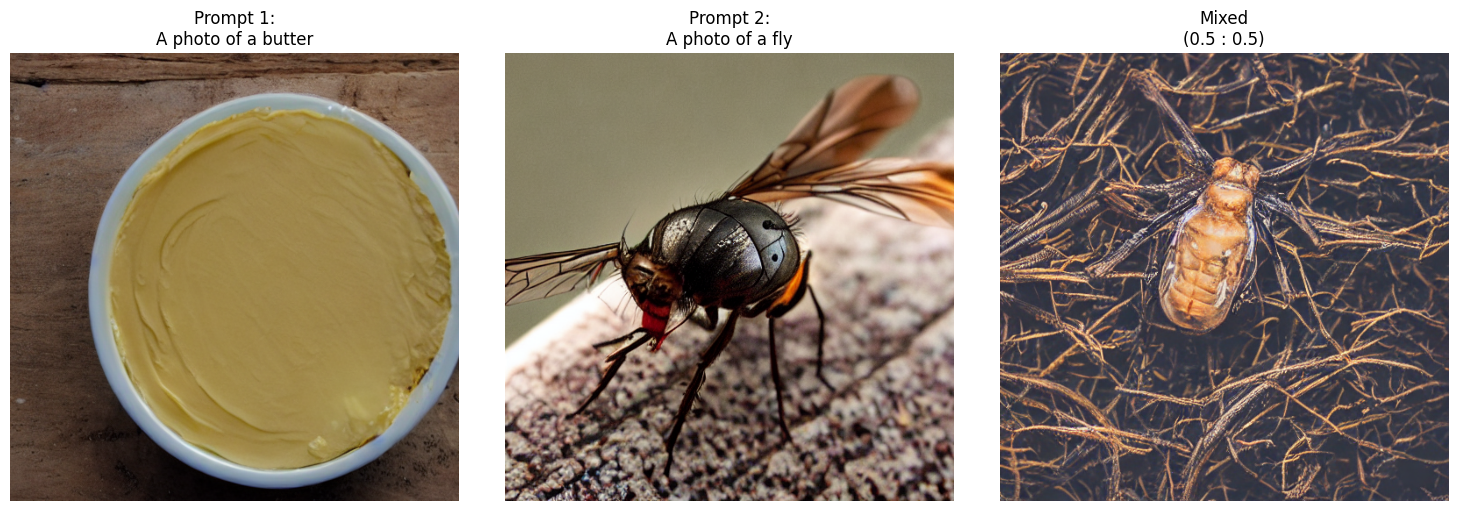

In [11]:
def get_unique_filename(base_path, base_name, extension):
    """Get a unique filename by adding a number if the file already exists"""
    counter = 0
    while True:
        suffix = f"_{counter}" if counter > 0 else ""
        full_path = base_path / f"{base_name}{suffix}{extension}"
        if not full_path.exists():
            return full_path
        counter += 1

for i in tqdm(range(30), desc="Generating images"):
    # Create output directories
    output_dir = Path('output_test')
    display_dir = output_dir / 'display'/ f'{class1}_{class2}'
    # 修改目录创建列表，为原始图像添加 original 子文件夹
    for dir_path in [f'original/{class1}', f'original/{class2}', f'mix/{class1}_{class2}', f'display/{class1}_{class2}']:
        (output_dir / dir_path).mkdir(parents=True, exist_ok=True)

    image_list = []
    # Generate and save images
    for embedding, class_name, filename_base in [
        (embedding1, f'original/{class1}', f'dog_{steps}steps_{guidance_scale}gs'),
        (embedding2, f'original/{class2}', f'airplane_{steps}steps_{guidance_scale}gs'),
        (mixed_embedding, f'mix/{class1}_{class2}', 
        f'dog_airplane_{mixing_ratio}ratio_{steps}steps_{guidance_scale}gs')
    ]:
        image = pipeline(
            prompt_embeds=embedding,
            num_inference_steps=steps,
            guidance_scale=guidance_scale,
        ).images[0]
        
        save_path = get_unique_filename(output_dir / class_name, filename_base, '.png')
        image.save(save_path)
        
        image_list.append(image)
    
    # 创建单个图形窗口
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot settings for each subplot
    for idx, (ax, img, title) in enumerate(zip(
        axes,
        image_list,
        [f'Prompt 1:\n{prompt1}', f'Prompt 2:\n{prompt2}', f'Mixed\n({mixing_ratio:.1f} : {1-mixing_ratio:.1f})']
    )):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()

    # Save and close the figure
    save_path = get_unique_filename(
        display_dir, 
        f'{class1}_{class2}_{mixing_ratio}ratio_{steps}steps_{guidance_scale}gs',
        '.png'
    )
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)  # 明确关闭这个图形